**Задание**: LLM классификация отзывов

**Метрика**: Weighted F1

**Time**: 5 секунд

# 1. Подготовка данных: text preprocessing

Анализируем train тексты

In [1]:
import pandas as pd
import numpy as np

In [3]:
data_train = pd.read_csv('train.csv')['text'].tolist()
data_train[:10]  # пример нескольких первых отзывов

['Заказали 14.10.2017 , получили 25.10.2017 \r\nНа мой размер 42, широкий как мешок. Надо было все таки размер  S заказать. \r\nПо поводу качества хороший пуховик. \r\nМех натуральный , съемный. \r\nБуду продавать .',
 'футболка хорошего качества,но футболка не как для девушек и женщин,а как на мужчину. она очень свободная. на свой М, заказала Л. теперь не знаю что делать,ибо она мне велика, даже моему папе она полезет.',
 'Все отлично!!!',
 'Рисунок не очень чёткий, а ткань прозрачная, видно нижнее бельё',
 'плохо!!!Низ рваный..деньги не вернули!Открыла спор,но его почему то закрыли',
 'обычная майка с ужасным запахом, есть косяки на белой надписи как краска',
 'Все как на фото, и цвет и форма.',
 'Но рост 180 по колено,качество хорошее,доставка быстрая',
 'Не подошло по размеру. Ткань тоже не понравилась',
 'очень крутой топ,заказала 11.11 пришел 28.11 еще и курьер принес']

Очистка и обработка текстов

In [4]:
# приводим к нижнему регистру
data_train = [i.lower() for i in data_train]

In [5]:
# удалим стоп-слова, HTML-тэги, цифры и знаки препинания
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def clean_text(text):
    # убираем HTML тэги
    text = BeautifulSoup(text, "lxml").text
    # убираем цифры и спецсимволы, оставляем только буквы и пробелы
    text = re.sub(r"[^а-яА-Яa-zA-Z\s]", " ", text)
    # убираем лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    # удаляем стоп-слова
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    text = ' '.join(tokens)
    return text

In [7]:
data_train = [clean_text(i) for i in data_train]

/tmp/ipython-input-3147282705.py:3: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "lxml").text


In [8]:
data_train[:5]

['заказали получили размер широкий мешок таки размер s заказать поводу качества хороший пуховик мех натуральный съемный буду продавать',
 'футболка хорошего качества футболка девушек женщин мужчину очень свободная свой м заказала л знаю делать ибо велика моему папе полезет',
 'отлично',
 'рисунок очень ч ткий ткань прозрачная видно нижнее бель',
 'плохо низ рваный деньги вернули открыла спор почему закрыли']

Датасет небольшой, здесь сделай аугментацию данных для получения большего количества обучающих примеров - через Back Translation

Back translation (ru - eng - ru)

In [9]:
!pip install transformers

In [10]:
from transformers import pipeline

# Может потребовать установки моделей
translator_en_ru = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru")
translator_ru_en = pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en")

def back_translation(text):
    # Русский -> Английский -> Русский
    en_text = translator_ru_en(text)[0]['translation_text']
    ru_text = translator_en_ru(en_text)[0]['translation_text']
    return ru_text

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [11]:
data_train_ru_eng = []

In [12]:
for i in data_train:
  data_train_ru_eng.append(back_translation(i))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your input_length: 511 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 510 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [13]:
data_train[:5]

['заказали получили размер широкий мешок таки размер s заказать поводу качества хороший пуховик мех натуральный съемный буду продавать',
 'футболка хорошего качества футболка девушек женщин мужчину очень свободная свой м заказала л знаю делать ибо велика моему папе полезет',
 'отлично',
 'рисунок очень ч ткий ткань прозрачная видно нижнее бель',
 'плохо низ рваный деньги вернули открыла спор почему закрыли']

In [14]:
data_train_ru_eng[:5]

['Заказал размер большой сумки, так что размер s закажи качество хороший мех натуральный, я продам',
 'Хорошая футболка девушек, её свободный мужчина приказал мне сделать это, потому что мой папа будет великолепен.',
 'Отлично.',
 'Рисунок очень аккуратный и прозрачный. Вы видите нижнее белье.',
 'Они вернули пари, потому что закрыли его.']

In [15]:
data_train_ru_eng = [clean_text(i) for i in data_train_ru_eng]

In [16]:
len(data_train_ru_eng)

1818

In [17]:
for i in data_train_ru_eng:
  data_train.append(i)

In [18]:
len(data_train)

3636

Проведём **лемматизацию**: все слова приведём к начальной форме

In [19]:
!pip install natasha

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 99.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=917c21ece40a7281fa29436f47059bd70b002f52f170d79babe084007088196c
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=ed8ecf2de02abf4dddde950a1d0222f4126c81a11a4f44bd145efff227285b97
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built docopt intervaltree


In [20]:
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def lemmatization(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return " ".join([t.lemma for t in doc.tokens])

In [21]:
data_train = [lemmatization(i) for i in data_train]

In [22]:
data_train = [clean_text(text) for text in data_train]

1. Построим гистограмму длин отзывов по количеству слов

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

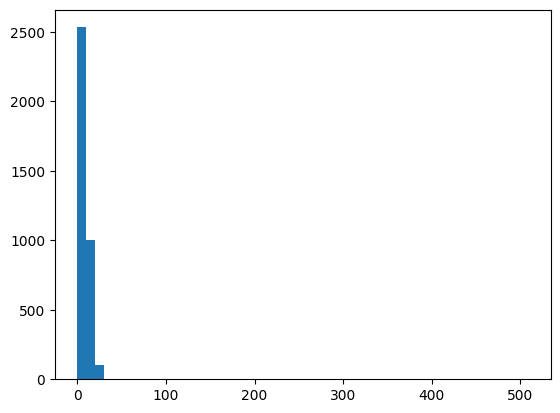

In [24]:
# строим гистограмму по количеству слов в отзыве
plt.hist([len(i.split()) for i in data_train], bins=50)
plt.show()

In [25]:
# посчитаем процент отзывов с разным количеством слов
small = len([i for i in data_train if len(i.split()) <= 2])*100 / len(data_train)

In [26]:
medium = len([i for i in data_train if len(i.split()) < 20 and len(i.split()) > 2])*100 / len(data_train)

In [27]:
large = len([i for i in data_train if len(i.split()) >= 20])*100 / len(data_train)

In [28]:
print(f'Процент отзывов, где менее 3 слов: {small}')
print(f'Процент отзывов, где от 3 до 19 слов: {medium}')
print(f'Процент отзывов, где более 19 слов: {large}')

Процент отзывов, где менее 3 слов: 8.525852585258527
Процент отзывов, где от 3 до 19 слов: 87.34873487348734
Процент отзывов, где более 19 слов: 4.125412541254126


Количество коротких отзывов около 6%, это не значительно

In [29]:
len(data_train)

3636

2. Построим WordCloud - проанализируем частотность слов

In [30]:
!pip install wordcloud

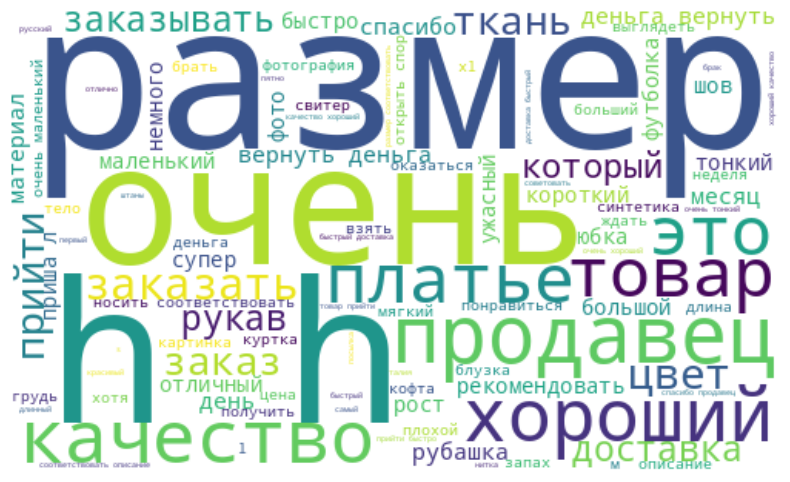

In [31]:
from wordcloud import WordCloud
all_train_text = " ".join(data_train)

wc = WordCloud(width=500, height=300, background_color="white",
               colormap="viridis", max_words=100).generate(all_train_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 2. Auto-labeling

Zero-shot классификация

In [33]:
import torch

In [34]:
# модель
classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
    device=0 if torch.cuda.is_available() else -1
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

Device set to use cuda:0


In [35]:
category = ['бытовая техника', 'обувь', 'одежда', 'посуда', 'текстиль', 'товары для детей', 'украшения и аксессуары', 'электроника', 'нет товара']

In [36]:
def zero_shot_labeling(texts, labels, confidence_threshold=0.7):
    results = []

    for i, text in enumerate(texts):
        if i % 100 == 0:
            print(f"Обработано {i}/{len(texts)} текстов...")

        result = classifier(text, labels, multi_label=False)

        predicted_label = result['labels'][0]
        confidence = result['scores'][0]

        results.append({
            'text': text,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'keep_for_training': confidence >= confidence_threshold
        })

    return pd.DataFrame(results)

In [39]:
# убираем пустые тексты
data_train = [i for i in data_train if len(i) > 0]

In [40]:
len(data_train)

3631

In [41]:
auto_labeled_df = zero_shot_labeling(data_train, category)

Обработано 0/3631 текстов...
Обработано 100/3631 текстов...
Обработано 200/3631 текстов...
Обработано 300/3631 текстов...
Обработано 400/3631 текстов...
Обработано 500/3631 текстов...
Обработано 600/3631 текстов...
Обработано 700/3631 текстов...
Обработано 800/3631 текстов...
Обработано 900/3631 текстов...
Обработано 1000/3631 текстов...
Обработано 1100/3631 текстов...
Обработано 1200/3631 текстов...
Обработано 1300/3631 текстов...
Обработано 1400/3631 текстов...
Обработано 1500/3631 текстов...
Обработано 1600/3631 текстов...
Обработано 1700/3631 текстов...
Обработано 1800/3631 текстов...
Обработано 1900/3631 текстов...
Обработано 2000/3631 текстов...
Обработано 2100/3631 текстов...
Обработано 2200/3631 текстов...
Обработано 2300/3631 текстов...
Обработано 2400/3631 текстов...
Обработано 2500/3631 текстов...
Обработано 2600/3631 текстов...
Обработано 2700/3631 текстов...
Обработано 2800/3631 текстов...
Обработано 2900/3631 текстов...
Обработано 3000/3631 текстов...
Обработано 3100/3631

In [43]:
auto_labeled_df.head()

,text,predicted_label,confidence,keep_for_training
0,заказать получить размер широкий мешок таки ра...,бытовая техника,0.676237,False
1,футболка хороший качество футболка девушка жен...,одежда,0.829552,True
2,отлично,текстиль,0.402512,False
3,рисунок очень ч ткий ткань прозрачный видно ни...,украшения и аксессуары,0.392344,False
4,плохо низ рваный деньга вернуть открыть спор п...,текстиль,0.728077,True


Получили размеченный датасет с признаками confidence и keep_for_training. Для дальнейшего дообучения модели оставим только те, что keep_for_training=True

In [44]:
qual_data_train = auto_labeled_df[auto_labeled_df['keep_for_training'] == True]

In [48]:
# остаётся совсем не много качественный примеров
qual_data_train.shape

(683, 4)

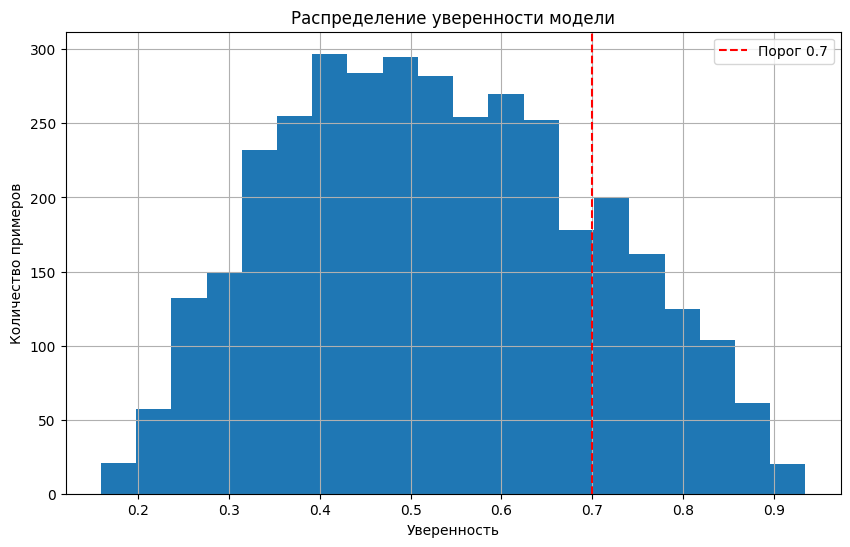

Статистика по категориям:
                        confidence  keep_for_training
predicted_label                                      
текстиль                  0.567852                499
одежда                    0.535995                 92
украшения и аксессуары    0.448869                 25
бытовая техника           0.441936                 23
товары для детей          0.540021                 21
посуда                    0.525853                 11
нет товара                0.426272                  6
электроника               0.508633                  6
обувь                     0.374595                  0


In [50]:
# распределение уверенности
plt.figure(figsize=(10, 6))
auto_labeled_df['confidence'].hist(bins=20)
plt.title('Распределение уверенности модели')
plt.xlabel('Уверенность')
plt.ylabel('Количество примеров')
plt.axvline(x=0.7, color='r', linestyle='--', label='Порог 0.7')
plt.legend()
plt.show()

# Статистика по категориям
category_stats = auto_labeled_df.groupby('predicted_label').agg({
    'confidence': 'mean',
    'keep_for_training': 'sum'
}).sort_values('keep_for_training', ascending=False)

print("Статистика по категориям:")
print(category_stats)

Для электроники, обуви и нет товара нет (или почти нет) хороших обучающих примеров. Возьмём хотя бы несколько с самыми высокими confidence.

In [51]:
rare_categories = ["электроника", "обувь", "нет товара"]

min_examples_per_category = 10  # Минимум примеров на категорию

supplemental_data = []

for category in rare_categories:
    # Берем все примеры этой категории
    category_examples = auto_labeled_df[auto_labeled_df['predicted_label'] == category]

    if len(category_examples) > 0:
        # Сортируем по уверенности (от высокой к низкой)
        sorted_examples = category_examples.sort_values('confidence', ascending=False)

        # Берем топ-N примеров
        n_to_take = min(min_examples_per_category, len(sorted_examples))
        top_examples = sorted_examples.head(n_to_take)

        print(f"Категория '{category}': взято {n_to_take} лучших примеров")
        supplemental_data.append(top_examples)
    else:
        print(f"Категория '{category}': нет примеров вообще")

# Объединяем с основными качественными данными
if supplemental_data:
    supplemental_df = pd.concat(supplemental_data)
    # ПОНИЖАЕМ ПОРОГ ДЛЯ ЭТИХ КАТЕГОРИЙ - помечаем как годные для обучения
    supplemental_df['keep_for_training'] = True

    # Объединяем с основными данными
    final_training_data = pd.concat([
        qual_data_train,  # исходные качественные данные
        supplemental_df     # дополнение для редких категорий
    ])
else:
    final_training_data = qual_data_train

Категория 'электроника': взято 10 лучших примеров
Категория 'обувь': взято 10 лучших примеров
Категория 'нет товара': взято 10 лучших примеров


In [56]:
final_training_data.shape

(713, 4)

In [57]:
# сохраним все предсказания
final_training_data.to_csv('final_training_data.csv', index=False)

In [58]:
final_training_data.head()

,text,predicted_label,confidence,keep_for_training
1,футболка хороший качество футболка девушка жен...,одежда,0.829552,True
4,плохо низ рваный деньга вернуть открыть спор п...,текстиль,0.728077,True
17,товар прийти заказать июля конец сентябрь слух...,текстиль,0.709295,True
22,отличный штаны очень т плый доставка неделя об...,одежда,0.743995,True
54,заказ идти неделя думать качество получше дырк...,одежда,0.729210,True


**Получили размеченный датасет**



In [59]:
X = final_training_data['text'].tolist()

In [66]:
category_ind = {'бытовая техника': 0, 'обувь': 1, 'одежда': 2,
                'посуда': 3, 'текстиль': 4, 'товары для детей': 5,
                'украшения и аксессуары': 6, 'электроника': 7, 'нет товара': 8}

In [61]:
pred_labels = final_training_data['predicted_label'].tolist()

In [67]:
y = [category_ind[label] for label in pred_labels]

In [76]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.33, random_state=42)

# 3. Дообучение модели с помощью LoRA и получение предсказание на test, в том числе среднее время обработки

In [69]:
!pip install transformers datasets accelerate peft

In [70]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from peft import LoraConfig, get_peft_model
import numpy as np

In [71]:
# базовая модель и токенизатор
model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=9)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "key", "value", "dense"], # адаптируем только attention-слои
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(base_model, lora_config)

In [74]:
enc_train = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
enc_val = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [77]:
train_ds = Dataset.from_dict({**enc_train, "labels": train_labels})
val_ds = Dataset.from_dict({**enc_val, "labels": val_labels})

In [78]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1_weighted": f1_score(labels, preds, average="weighted")}

In [84]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="f1_weighted",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-3028747189.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Weighted
1,No log,0.770803,0.711514
2,No log,0.753316,0.721507
3,No log,0.744043,0.724444
4,0.800900,0.727430,0.727538
5,0.800900,0.723385,0.725382
6,0.800900,0.698840,0.734711
7,0.765100,0.716969,0.738494
8,0.765100,0.686914,0.737476
9,0.765100,0.680586,0.743536
10,0.702500,0.675549,0.747451


TrainOutput(global_step=750, training_loss=0.5785208943684896, metrics={'train_runtime': 48.945, 'train_samples_per_second': 487.282, 'train_steps_per_second': 15.323, 'total_flos': 22305935163600.0, 'train_loss': 0.5785208943684896, 'epoch': 50.0})

Метрика вышла на плато -> останавливаю обучение

In [86]:
from transformers import AutoModelForSequenceClassification

best_model = AutoModelForSequenceClassification.from_pretrained(
    "best_rubert_model",
    num_labels=9,  # ← КРИТИЧЕСКИ ВАЖНО: укажите 9 классов!
    ignore_mismatched_sizes=True  # игнорировать несовпадение размеров
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Посмотрим на sample submission

In [87]:
sample = pd.read_csv('submission_example.csv')
sample.head(3)

,category
0,бытовая техника
1,нет товара
2,обувь


Загружаем test.csv

In [88]:
test_df = pd.read_csv('test.csv')
test_texts = test_df['text'].tolist()

In [90]:
test_df.shape

(7276, 1)

In [99]:
import time

In [100]:
def predict_categories(texts, model, tokenizer, label_map):  # с замером среднего времени обработки
    predictions = []
    work_time = []
    for i, text in enumerate(texts):
        begin_time = time.time()
        if i % 100 == 0:
            print(f"Обработано {i}/{len(texts)}...")

        # Токенизация
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )

        # Предсказание
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).item()

        # Преобразование в текстовую метку
        predicted_label = label_map[predicted_class]
        predictions.append(predicted_label)
        end_time = time.time()
        work_time.append(end_time - begin_time)

    return predictions, work_time

In [92]:
category_ind  # надо сделать обратный

{'бытовая техника': 0,
 'обувь': 1,
 'одежда': 2,
 'посуда': 3,
 'текстиль': 4,
 'товары для детей': 5,
 'украшения и аксессуары': 6,
 'электроника': 7,
 'нет товара': 8}

In [94]:
category_ind_back = {
    0: 'бытовая техника', 1: 'обувь', 2: 'одежда',
    3: 'посуда', 4: 'текстиль', 5: 'товары для детей',
    6: 'украшения и аксессуары', 7: 'электроника', 8: 'нет товара'
}

In [101]:
predicted_labels = predict_categories(test_texts, best_model, tokenizer, category_ind_back)

Обработано 0/7276...
Обработано 100/7276...
Обработано 200/7276...
Обработано 300/7276...
Обработано 400/7276...
Обработано 500/7276...
Обработано 600/7276...
Обработано 700/7276...
Обработано 800/7276...
Обработано 900/7276...
Обработано 1000/7276...
Обработано 1100/7276...
Обработано 1200/7276...
Обработано 1300/7276...
Обработано 1400/7276...
Обработано 1500/7276...
Обработано 1600/7276...
Обработано 1700/7276...
Обработано 1800/7276...
Обработано 1900/7276...
Обработано 2000/7276...
Обработано 2100/7276...
Обработано 2200/7276...
Обработано 2300/7276...
Обработано 2400/7276...
Обработано 2500/7276...
Обработано 2600/7276...
Обработано 2700/7276...
Обработано 2800/7276...
Обработано 2900/7276...
Обработано 3000/7276...
Обработано 3100/7276...
Обработано 3200/7276...
Обработано 3300/7276...
Обработано 3400/7276...
Обработано 3500/7276...
Обработано 3600/7276...
Обработано 3700/7276...
Обработано 3800/7276...
Обработано 3900/7276...
Обработано 4000/7276...
Обработано 4100/7276...
Обра

In [102]:
submission_df = pd.DataFrame({
    'category': predicted_labels[0]
})

submission_df.to_csv('my_submission1.csv', index=False)

In [104]:
time_preprocess = np.array(predicted_labels[1]).mean()

In [105]:
print(f'Среднее время обработки 1 текста в тестовой выборке = {time_preprocess}')

Среднее время обработки 1 текста в тестовой выборке = 0.007701161210519917
